<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/Local_Rounds/qFedAvg/qFederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g78i-iB4ZUThHzYwRp3RfUKMu77Z6dltujjZCtB7CgqnbPJZvQa6Vc


## Imports

In [2]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from sklearn.metrics import f1_score

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Tue May  4 06:23:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [3]:
torch.cuda.set_device('cuda:0')

In [4]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw




Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Processing...
Done!


In [5]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [6]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [7]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [8]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


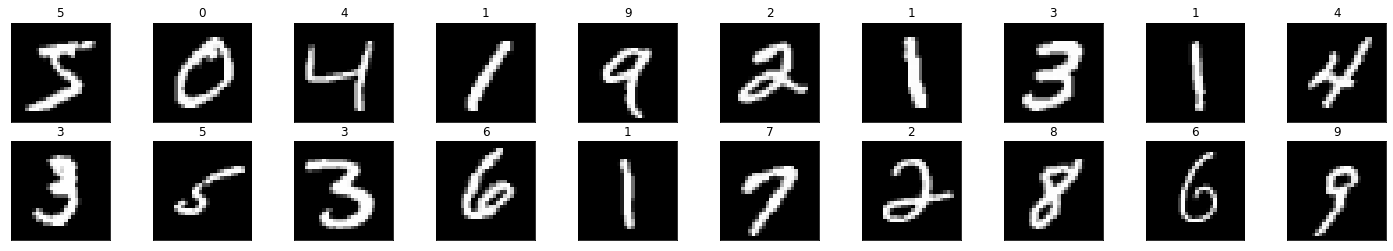

In [9]:
visualize(mnist_data_train)

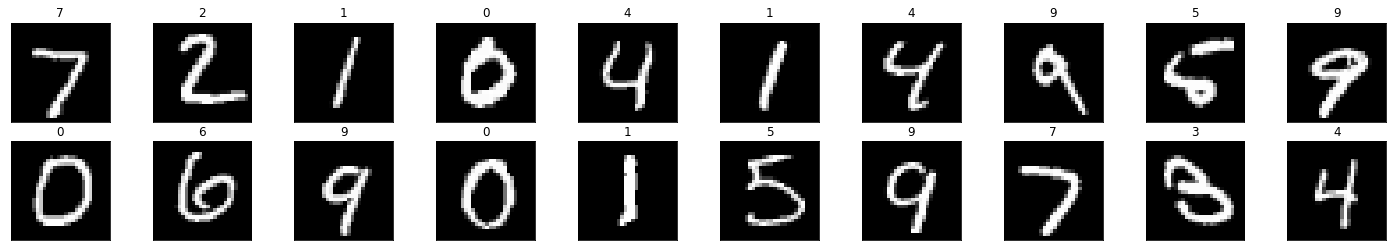

In [10]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [11]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [12]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict


## Models

In [13]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [14]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [15]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## q Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [16]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label


class ClientUpdate(object):
  def __init__(self, dataset, batch_size, learning_rate, epochs, idxs, q=None):
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs
    self.q = q
    if not self.q:
        # TODO: Client itself adjust fairness 
        pass
    self.mu = 1e-10

  def train(self, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    e_loss = []

    model_weights = copy.deepcopy(model.state_dict())
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      # for data, labels in tqdm(self.train_loader):
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)


    total_loss = sum(e_loss)/len(e_loss)

    # delta weights
    model_weights_new = copy.deepcopy(model.state_dict())
    L = 1.0 / self.learning_rate

    delta_weights, delta, h = {}, {}, {}
    loss_q = np.float_power(total_loss + self.mu, self.q)
    # updating the global weights
    for k in model_weights_new.keys():
      delta_weights[k] = (model_weights[k] - model_weights_new[k]) * L
      delta[k] =  loss_q * delta_weights[k]
      # Estimation of the local Lipchitz constant
      h[k] = (self.q * np.float_power(total_loss + self.mu, self.q - 1) * torch.pow(torch.norm(delta_weights[k]), 2)) + (L * loss_q)

    return delta, h, total_loss

### Server Side Training


In [17]:
def client_sampling(n, m, weights=None, with_replace=False):
    pk = None
    if weights:
        total_weights = np.sum(np.asarray(weights))
        pk = [w * 1.0 / total_weights for w in weights]

    return np.random.choice(range(n), m, replace=with_replace, p=pk)

In [18]:
def training(model, rounds, batch_size, lr, ds, ds_test, data_dict, C, K, E, q, sampling, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - ds_test:         Dataset used for testing
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  # train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []
  f1_macro = []
  f1_weighted = []

  # client weights by total samples
  p_k = None
  if sampling == 'weighted':
    p_k = [len(data_dict[c]) for c in data_dict] if ds else [len(data_dict[c]['train_ds']) for c in data_dict]

  # Time log
  start_time = time.time()

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    deltas, hs, local_loss = [], [], []

    m = max(int(C*K), 1)    
    S_t = client_sampling(K, m, weights=p_k, with_replace=False)

    print('Round: {} Picking {}/{} clients: {}'.format(curr_round, m, K, S_t))

    global_weights = model.state_dict()

    for k in range(len(S_t)):
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
      local_update = ClientUpdate(dataset=ds_, batch_size=batch_size, learning_rate=lr, epochs=E, idxs=idxs, q=q)
      delta_k, h_k, loss = local_update.train(model=copy.deepcopy(model))

      deltas.append(copy.deepcopy(delta_k))
      hs.append(copy.deepcopy(h_k))
      local_loss.append(copy.deepcopy(loss))

    # Perform qFedAvg
    h_sum = copy.deepcopy(hs[0])
    delta_sum = copy.deepcopy(deltas[0])
    
    for k in h_sum.keys():
        for i in range(1, len(hs)):
            h_sum[k] += hs[i][k]
            delta_sum[k] += deltas[i][k]

    new_weights = {}
    for k in delta_sum.keys():
        for i in range(len(deltas)):
            new_weights[k] = delta_sum[k] / h_sum[k]

    # Updating global model weights
    for k in global_weights.keys():
        global_weights[k] -= new_weights[k]

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

    # test
    test_criterion = nn.CrossEntropyLoss()
    test_accuracy_current, test_loss_current, f1_macro_current, f1_weighted_current =  testing(copy.deepcopy(model), ds_test, 128, test_criterion, num_classes, classes_test)
    test_accuracy.append(test_accuracy_current)
    test_loss.append(test_loss_current)
    f1_macro.append(f1_macro_current)
    f1_weighted.append(f1_weighted_current)

  end_time = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Train_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_loss.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(test_accuracy)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Test Accuracy',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_Test_Accuracy.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_macro)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Macro',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Marco.jpg', format='jpg')
  plt.show()

  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(f1_weighted)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='F1 Weighted',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'_F1_Weighted.jpg', format='jpg')
  plt.show()

  print("Training Done!")
  print("Total time taken to Train: {}\n\n".format(end_time-start_time))
  
  return model, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted

## Testing Loop

In [19]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_info=False):
  #test loss 
  test_loss = 0.0
  y_true, y_hat = None, None

  correct_class = list(0 for i in range(num_classes))
  total_class = list(0 for i in range(num_classes))

  if hasattr(dataset, 'dataloader'):
    test_loader = dataset.dataloader(batch_size=bs, shuffle=False)
  else:
    test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

  l = len(test_loader)

  model.eval()
  for i, (data, labels) in enumerate(test_loader):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, dim=1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    for i, lbl in enumerate(labels.data):
      try:
        correct_class[lbl.item()] += correct[i]
        total_class[lbl.item()] += 1
      except:
          print('Error', lbl, i)
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)
  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')

  if print_info:
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(10):
      if total_class[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
              (classes[i], 100 * correct_class[i] / total_class[i],
              np.sum(correct_class[i]), np.sum(total_class[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
          100. * np.sum(correct_class) / np.sum(total_class),
          np.sum(correct_class), np.sum(total_class)))

    print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))
  
  return test_accuracy, test_loss, f1_macro, f1_weighted

## Logger

In [20]:
log_dict = {}
NUM_REPEAT = 1

## MNIST CNN on IID

### Train


Experiment Run Number:  0
Round: 1 Picking 30/100 clients: [14 67 62 15 39 17  2 22 31 48 71 49 58 53 61 55 92  7 13 44  0 26 96 94
 87 59 35 97 27 16]
Round: 1... 	Average Loss: 0.519
Round: 2 Picking 30/100 clients: [79 82 29 58 45 40 70 73 46  0 91 97  3 19 50  7 36 42 68 44 11 93 99 65
 84 61 72 39 17  1]
Round: 2... 	Average Loss: 0.194
Round: 3 Picking 30/100 clients: [97 99 28 35 33 12 76  5 24 71 64 48 94 70 52  0  1 23 31 11 34 84  4 25
 82 78 67 54 87 89]
Round: 3... 	Average Loss: 0.121
Round: 4 Picking 30/100 clients: [39 80  3 47 40 74 65 38  5 29 79 93 60 98 69  4 50 25 94 85 81 32 37 24
 12 73 99 31 17  8]
Round: 4... 	Average Loss: 0.086
Round: 5 Picking 30/100 clients: [32 29 44 21 82 56  6 40  7 47 46 28 51 10 45 85 92 55 15 77 52 83 81 25
 86 76 73 80 27 78]
Round: 5... 	Average Loss: 0.069
Round: 6 Picking 30/100 clients: [41 63 97 17 64 19 57 85  3 23 11 16 61 35 69 77 59 91 72 22 75 92 93 89
  2 34 46  6 56 87]
Round: 6... 	Average Loss: 0.064
Round: 7 Picking 30/

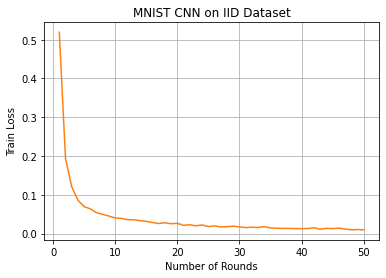

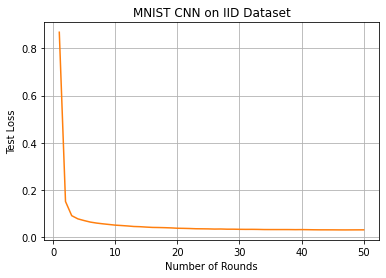

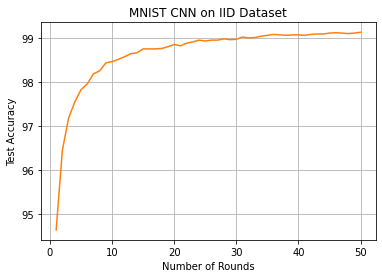

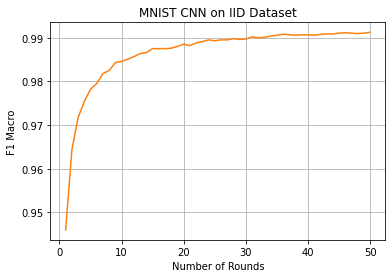

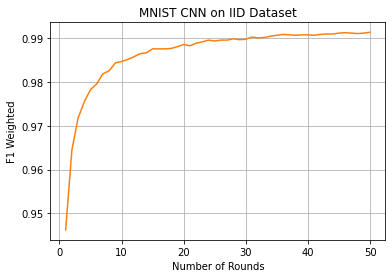

Training Done!
Total time taken to Train: 3296.7504332065582




In [21]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.3
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # data partition dictionary
  iid_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, iid_dict, C, K, E, q, sampling, "MNIST CNN on IID Dataset", "orange")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [22]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.030962

Test Accuracy of     0: 99% (977/980)
Test Accuracy of     1: 99% (1134/1135)
Test Accuracy of     2: 99% (1028/1032)
Test Accuracy of     3: 99% (1000/1010)
Test Accuracy of     4: 99% (977/982)
Test Accuracy of     5: 98% (883/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 98% (962/974)
Test Accuracy of     9: 98% (991/1009)

Final Test  Accuracy: 99.140 (9914/10000)
F1 Score: 0.991276 (macro) 0.991397 (weighted) %



In [23]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST CNN on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST CNN on Non IID

### Train


Experiment Run Number:  0
Round: 1 Picking 30/100 clients: [65  5 60  0 31  3 32 45 64 20 58 15 69 26 97  7 95 52 96 24 18 37 75 25
 19 66 83 23 68 70]
Round: 1... 	Average Loss: 0.119
Round: 2 Picking 30/100 clients: [17 85 94  5 73 28 66 58 64  9 69 10 36  0 90 44 26 24 95 60 52 68  4 21
 19 97 83 47 80 37]
Round: 2... 	Average Loss: 0.084
Round: 3 Picking 30/100 clients: [95 41 11 14 71 19 44 81 80 57 25 74 13 93 36 48 47 70 39  4 42 40 55 15
 17 79 34 10 97 49]
Round: 3... 	Average Loss: 0.045
Round: 4 Picking 30/100 clients: [90 84 52 34 65  8 59 86 13 36 25 88  7 55 95 54 18 39 31 69 66 64  2 92
 73 37 21 45 79 12]
Round: 4... 	Average Loss: 0.033
Round: 5 Picking 30/100 clients: [87 53 39 64 27 14 74 92 18 96 40 28 58 51 80 45 82 56 73 63 13 70 83 57
 34  7 54 31 10 11]
Round: 5... 	Average Loss: 0.03
Round: 6 Picking 30/100 clients: [12 62 79 18 58 53 66 30 44 60 69 91 32 55 51 45 73 72 13  8 75 68 63 25
 52 34 11 96 67 14]
Round: 6... 	Average Loss: 0.024
Round: 7 Picking 30/1

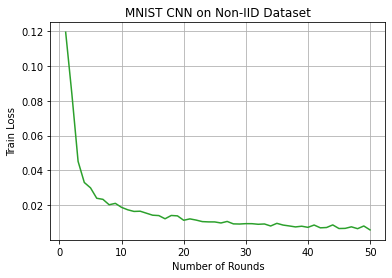

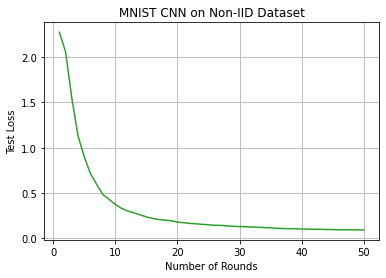

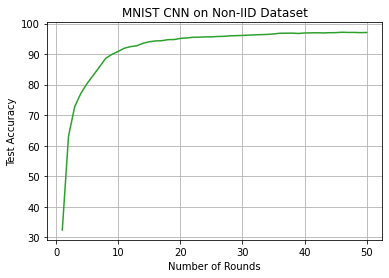

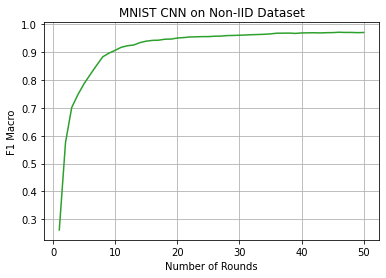

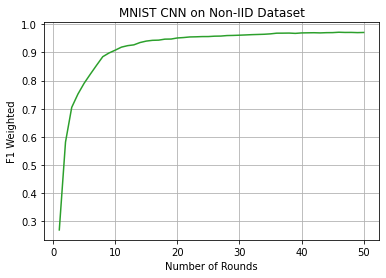

Training Done!
Total time taken to Train: 3271.571305036545




In [24]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.3
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_cnn = MNIST_CNN()

  if torch.cuda.is_available():
    mnist_cnn.cuda()

  mnist_cnn_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST CNN on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [25]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.093849

Test Accuracy of     0: 98% (967/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 95% (990/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 94% (926/982)
Test Accuracy of     5: 93% (831/892)
Test Accuracy of     6: 98% (947/958)
Test Accuracy of     7: 98% (1014/1028)
Test Accuracy of     8: 96% (940/974)
Test Accuracy of     9: 96% (976/1009)

Final Test  Accuracy: 97.100 (9710/10000)
F1 Score: 0.970701 (macro) 0.970971 (weighted) %



In [26]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST CNN on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on IID

### Train

Experiment Run Number:  0
Round: 1 Picking 30/100 clients: [90 85 35 58 49  7 20 91 70 15 55 68 41  4 69 62 96 21  0 84 67 92  9  1
  2 28 50 98 19 78]
Round: 1... 	Average Loss: 0.511
Round: 2 Picking 30/100 clients: [25 48 60 52 56 14 99 54 24 65 21 72 78 41 30  2 50 73 58 12 38 98 16 80
 70 63 74 51 87  7]
Round: 2... 	Average Loss: 0.212
Round: 3 Picking 30/100 clients: [66 49 81 27 75 48 88 86 61 84 33 16 28 64  3 38 90  0  7 41 65 53 54 59
 11 67 26 83  1 85]
Round: 3... 	Average Loss: 0.156
Round: 4 Picking 30/100 clients: [57 86 82 35 45 48  9 26 87 69 63  4 42 47 32 68 49 66 39 15 94 56 67 92
 84 27 64 71 50 98]
Round: 4... 	Average Loss: 0.133
Round: 5 Picking 30/100 clients: [60 26 40 53 16  6  8 84 38 63 59 75 85 48 66  7 25 18  1 77 57  4 92 52
 93 73 31 99  3  9]
Round: 5... 	Average Loss: 0.115
Round: 6 Picking 30/100 clients: [47 76 65 87 12 34 11 38 24 63 23 19 97 42  4 13 96 95 64 52 82 55  8 72
 77  2 48 74 83 27]
Round: 6... 	Average Loss: 0.103
Round: 7 Picking 30/

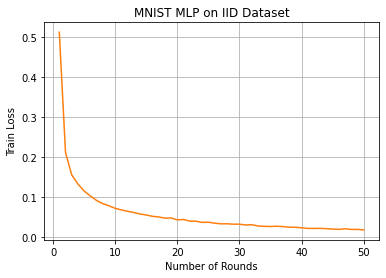

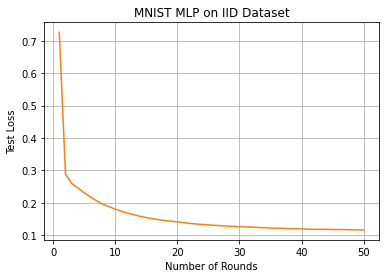

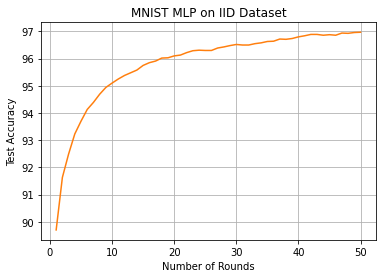

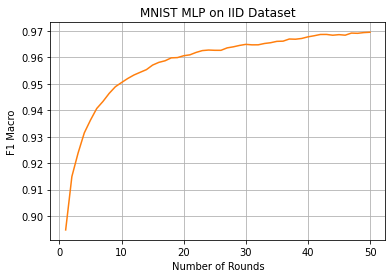

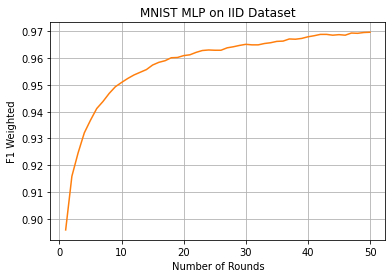

Training Done!
Total time taken to Train: 1729.2521929740906




In [27]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)

  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.3
  # number of clients
  K = 100
  # number of training passes on local dataset for each round
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'
  # dict containing different type of data partition
  data_dict = iid_partition(mnist_data_train, 100)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST MLP on IID Dataset", "orange")
  
  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [28]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.116712

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 96% (992/1032)
Test Accuracy of     3: 97% (980/1010)
Test Accuracy of     4: 96% (950/982)
Test Accuracy of     5: 96% (858/892)
Test Accuracy of     6: 97% (933/958)
Test Accuracy of     7: 96% (991/1028)
Test Accuracy of     8: 96% (936/974)
Test Accuracy of     9: 95% (965/1009)

Final Test  Accuracy: 96.970 (9697/10000)
F1 Score: 0.969473 (macro) 0.969677 (weighted) %



In [29]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST MLP on IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## MNIST MLP on Non IID

### Train

Experiment Run Number:  0
Round: 1 Picking 30/100 clients: [89 56 79 82 64  4 26 49 25 47 96 24 63  9 38 55 27 94 97 58  6 41 98 70
 28 66 93 91  1  8]
Round: 1... 	Average Loss: 0.13
Round: 2 Picking 30/100 clients: [25 42 52 83 39 57 77 79 36 21  4 61 64 43 72 30 67 62 20 53  0  9 92 41
 75 94 84  2 70 91]
Round: 2... 	Average Loss: 0.069
Round: 3 Picking 30/100 clients: [40 29 93 38 83 70 55 16 50  0 23 41 11 46 61 72 82 59 43 66  5 17 28 36
 94 47 22 73 33 19]
Round: 3... 	Average Loss: 0.057
Round: 4 Picking 30/100 clients: [33 74 11 19 28 24 26 50 80 84 10 94  7 88 63 92 48 35 54 52 93  1 43 66
 45 70 30 22 49 56]
Round: 4... 	Average Loss: 0.045
Round: 5 Picking 30/100 clients: [26 43 89 84 14 68  8 61 28 30 42 27 57 46 72 55 37 78 16 87 96  7  9 67
 49 38 12 41 62 34]
Round: 5... 	Average Loss: 0.041
Round: 6 Picking 30/100 clients: [51 10 35 23  4 12 49 41  7 97 77 79 72 67 39 31 25 34 54 33 47 96  0 21
 69 92 86 83  5  8]
Round: 6... 	Average Loss: 0.035
Round: 7 Picking 30/1

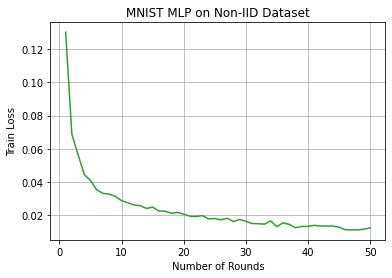

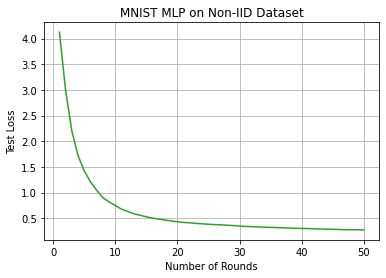

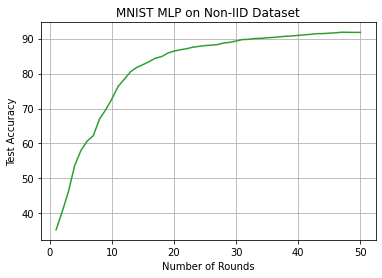

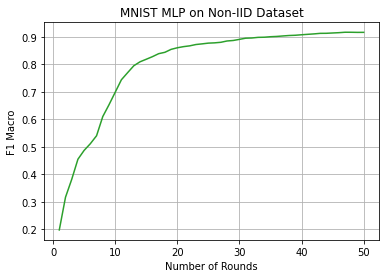

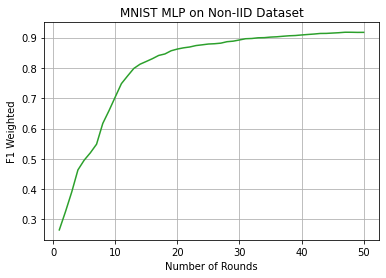

Training Done!
Total time taken to Train: 1766.95143699646




In [30]:
train_loss_multiple_runs = [None] * NUM_REPEAT
test_accuracy_multiple_runs = [None] * NUM_REPEAT
test_loss_multiple_runs = [None] * NUM_REPEAT
f1_macro_multiple_runs = [None] * NUM_REPEAT
f1_weighted_multiple_runs = [None] * NUM_REPEAT

for exp_num in range(NUM_REPEAT):
  print("Experiment Run Number: ", exp_num)
  
  # number of training rounds
  rounds = 50
  # client fraction
  C = 0.3
  # number of clients
  K = 100
  # number of training passes on local dataset for each roung
  E = 5
  # batch size
  batch_size = 10
  # learning Rate
  lr=0.05
  # fairness
  q = 0.001
  # sampling
  # sampling = 'uniform'
  sampling = 'weighted'

  # dict containing different type of data partition
  data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
  # load model
  mnist_mlp = MNIST_2NN()

  if torch.cuda.is_available():
    mnist_mlp.cuda()

  mnist_mlp_non_iid_trained, train_loss, test_accuracy, test_loss, f1_macro, f1_weighted = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, mnist_data_test, data_dict, C, K, E, q, sampling, "MNIST MLP on Non-IID Dataset", "green")

  train_loss_multiple_runs[exp_num] = train_loss
  test_accuracy_multiple_runs[exp_num] = test_accuracy
  test_loss_multiple_runs[exp_num] = test_loss
  f1_macro_multiple_runs[exp_num] = f1_macro
  f1_weighted_multiple_runs[exp_num] = f1_weighted

### Test

In [31]:
criterion = nn.CrossEntropyLoss()
acc, loss, f1_macro, f1_weighted = testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test, True)

Test Loss: 0.271080

Test Accuracy of     0: 92% (907/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 91% (945/1032)
Test Accuracy of     3: 93% (945/1010)
Test Accuracy of     4: 84% (830/982)
Test Accuracy of     5: 95% (849/892)
Test Accuracy of     6: 96% (923/958)
Test Accuracy of     7: 96% (989/1028)
Test Accuracy of     8: 79% (774/974)
Test Accuracy of     9: 88% (892/1009)

Final Test  Accuracy: 91.780 (9178/10000)
F1 Score: 0.916407 (macro) 0.917258 (weighted) %



In [32]:
hyperparams = {'rounds': rounds,
               'C': C,
               'K': K,
               'E': E,
               'batch_size': batch_size,
               'lr': lr,
               'q': q,
               'sampling': sampling
               }

log_dict['MNIST MLP on Non IID'] = {'train_loss': train_loss_multiple_runs, 
                                'test_loss': test_loss_multiple_runs, 
                                'test_accuracy': test_accuracy_multiple_runs,
                                'f1_macro': f1_macro_multiple_runs,
                                'f1_weighted': f1_weighted_multiple_runs,
                                'hyperparams': hyperparams,
                                }

## Pickle Log

In [33]:
import pickle
 
with open(path + 'Local_Round_qFedAvg_5.pkl', 'wb') as file:
  pickle.dump(log_dict, file)

In [34]:
log_dict

{'MNIST CNN on IID': {'f1_macro': [[0.9459999474430016,
    0.9643231494336779,
    0.971702008386365,
    0.975412926867912,
    0.9782328796789892,
    0.9795116656410519,
    0.9818053571420118,
    0.9825034618482611,
    0.984310284970039,
    0.9846037116650388,
    0.9851108504074316,
    0.9856926931726375,
    0.9864032317147927,
    0.9866108499106968,
    0.987519834886975,
    0.9875224831263599,
    0.9875188170830451,
    0.9876211023158371,
    0.988026509453477,
    0.9885285517008422,
    0.9882261991388956,
    0.9888211348671836,
    0.9891305554352245,
    0.9895276518641944,
    0.989323529970723,
    0.9895292676439059,
    0.9895233686555163,
    0.9898156683611752,
    0.9896167897087578,
    0.9897176807927288,
    0.9902183797572238,
    0.9900243733276023,
    0.9901138970494655,
    0.9904037620791554,
    0.9905966834482156,
    0.9908095052753902,
    0.9907082478854564,
    0.9905912994671416,
    0.9906921967508223,
    0.9906906144672657,
    0.99059146

In [35]:
import pickle

with open(path + 'Local_Round_qFedAvg_5.pkl', 'rb') as file:
  log_dict = pickle.load(file)

In [36]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on IID']['test_accuracy']])

[99.14]


In [37]:
print([test_acc[-1] for test_acc in log_dict['MNIST CNN on Non IID']['test_accuracy']])

[97.1]


In [38]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on IID']['test_accuracy']])

[96.97]


In [39]:
print([test_acc[-1] for test_acc in log_dict['MNIST MLP on Non IID']['test_accuracy']])

[91.78]


In [40]:
output.show()

Mounted at /content/drive
